In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data

In [2]:
# total number of datapoints
n = 10

# parameters of distribution (alpha - mixture coeficient, mu - mean, s - scale)
alpha_true = 0.5
mu1_true, s1_true = 0, 1
mu2_true, s2_true = 10, 3

In [3]:
# dataset generation

size_A = int(alpha_true * n)
A = np.random.normal(loc=mu1_true, scale=s1_true, size=(1, size_A))
B = np.random.normal(loc=mu2_true, scale=s2_true, size=(1, n - size_A))
data = np.c_[(A, B)][0]
true_label = np.c_[(np.zeros_like(A), np.ones_like(B))][0]

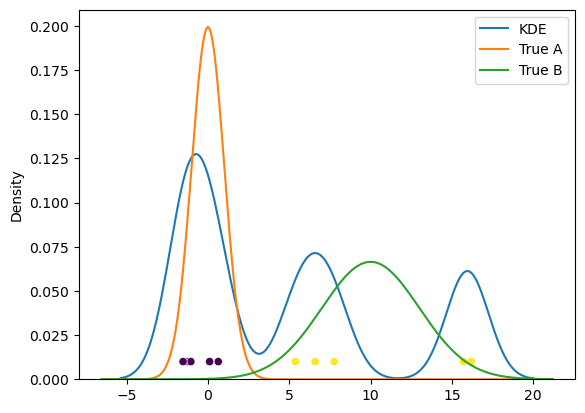

In [4]:
def plot_data(data):
    sns.scatterplot(x=data, y=np.full_like(data, 0.01), c=true_label)
    sns.kdeplot(data, bw_adjust=.3, label="KDE")
    
    x = np.linspace(data.min() - 5, data.max() + 5, 300)
    plt.plot(x, alpha_true * stats.norm.pdf(x, loc=mu1_true, scale=s1_true), c=sns.color_palette()[1], label="True A")
    plt.plot(x, (1 - alpha_true) * stats.norm.pdf(x, loc=mu2_true, scale=s2_true), c=sns.color_palette()[2], label="True B")
    plt.legend()
    
def plot_iteration(data, alpha, params1, params2):
    mu1, s1 = params1
    mu2, s2 = params2
    
    print("Current state:")
    print(f"  alpha: {alpha:.2f}")
    print(f"  params A: mu={mu1:.2f} s={s1:.2f} (true: mu={mu1_true:.2f} s={s1_true:.2f})")
    print(f"  params B: mu={mu2:.2f} s={s2:.2f} (true: mu={mu2_true:.2f} s={s2_true:.2f})")
    
    plot_data(data)
    x = np.linspace(data.min() - 5, data.max() + 5, 300)
    plt.plot(x, alpha * stats.norm.pdf(x, loc=mu1, scale=s1), 
             linestyle="dotted", c=sns.color_palette()[1], label="Estimate A")
    plt.plot(x, (1 - alpha) * stats.norm.pdf(x, loc=mu2, scale=s2), 
             linestyle="dotted", c=sns.color_palette()[2], label="Estimate B")
    plt.legend()
    plt.show()
    
plot_data(data)

# EM Code

In [5]:
def weighted_mean_and_std(data, weights):
    besel_corr = len(data) / (len(data) - 1)
    
    mean = np.average(data, weights=weights)
    std = np.sqrt(
        besel_corr * np.average(
            (data - mean) ** 2, 
            weights=weights
        )
    )
    return mean, std

In [6]:
def expect(data, alpha, params1, params2):
    mu1, s1 = params1
    mu2, s2 = params2
    
    # P(X|C)
    e1 = stats.norm.pdf(data, loc=mu1, scale=s1)
    e2 = stats.norm.pdf(data, loc=mu2, scale=s2)
    
    # prior for individual components
    prior_c0 = alpha
    prior_c1 = 1 - alpha
    
    # P(X|C) P(C) or P(X, C)
    p_x0 = e1 * prior_c0
    p_x1 = e2 * prior_c1

    # P(X) by the law of total probability
    p_x = p_x0 + p_x1
    
    # P(C|X)
    p0 = p_x0 / p_x
    p1 = p_x1 / p_x
    
    return np.r_[(p0[np.newaxis], p1[np.newaxis])]


def maximize(data, expectation):
    
    w1 = expectation[0]  # P(C=0|X)
    w2 = expectation[1]  # P(C=1|X)
    
    alpha = w1.sum() / (w1.sum() + w2.sum())
    
    mu1, s1 = weighted_mean_and_std(data, w1)
    mu2, s2 = weighted_mean_and_std(data, w2)

    return alpha, (mu1, s1), (mu2, s2)

# Optimization Loop

Current state:
  alpha: 0.36
  params A: mu=1.41 s=4.30 (true: mu=0.00 s=1.00)
  params B: mu=6.81 s=7.03 (true: mu=10.00 s=3.00)


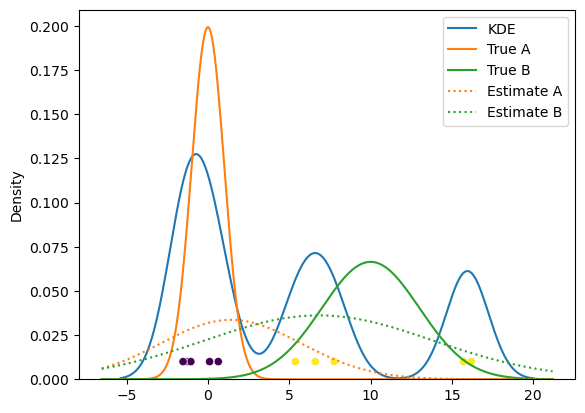

Current state:
  alpha: 0.48
  params A: mu=-0.64 s=0.87 (true: mu=0.00 s=1.00)
  params B: mu=9.87 s=5.30 (true: mu=10.00 s=3.00)


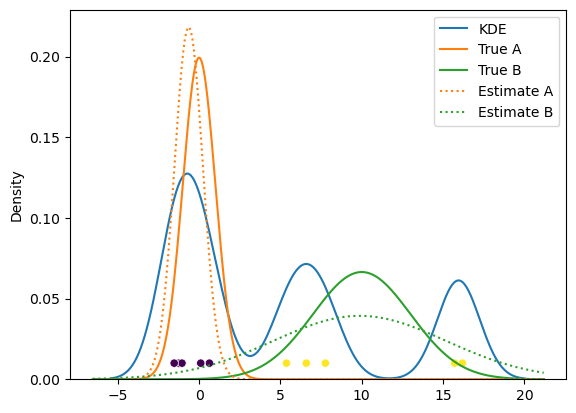

Current state:
  alpha: 0.48
  params A: mu=-0.64 s=0.87 (true: mu=0.00 s=1.00)
  params B: mu=9.87 s=5.30 (true: mu=10.00 s=3.00)


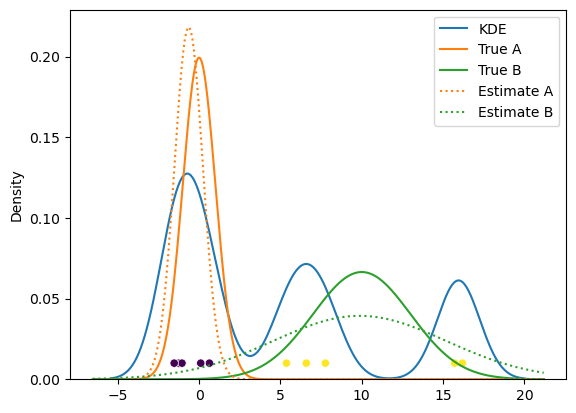

Current state:
  alpha: 0.48
  params A: mu=-0.64 s=0.87 (true: mu=0.00 s=1.00)
  params B: mu=9.87 s=5.30 (true: mu=10.00 s=3.00)


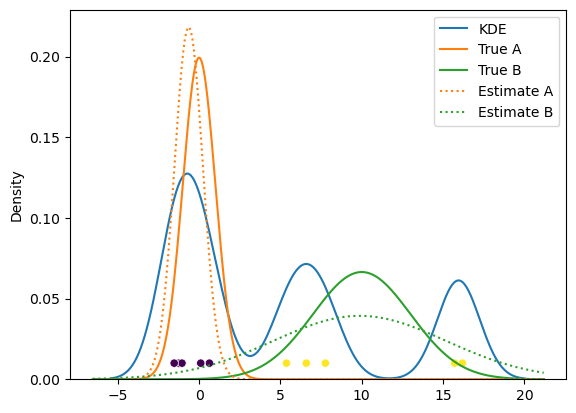

Current state:
  alpha: 0.48
  params A: mu=-0.64 s=0.87 (true: mu=0.00 s=1.00)
  params B: mu=9.87 s=5.30 (true: mu=10.00 s=3.00)


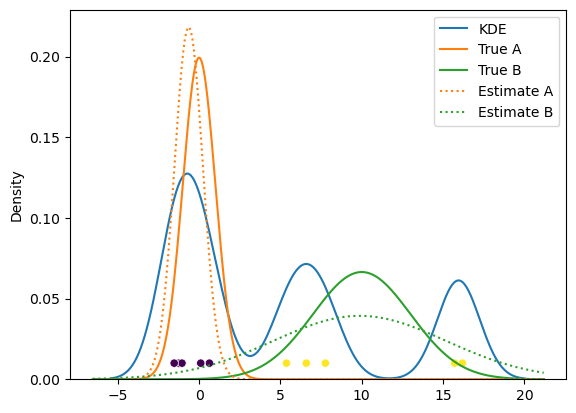

In [7]:
TOTAL_ITERATIONS = 100
PLOT_EVERY_N_ITERATION = 30

# initial guess
alpha = .5
params1 = .1, 2
params2 = .8, 2

for i in range(TOTAL_ITERATIONS):
    
    # EXPECT
    e = expect(data, alpha, params1, params2)
    
    # MAXIMIZE
    alpha, params1, params2 = maximize(data, e)
    
    if i % PLOT_EVERY_N_ITERATION == 0:
        plot_iteration(data, alpha, params1, params2)

plot_iteration(data, alpha, params1, params2)